In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Step 2 : Load Data from File & Create DataFrame
file_path = "D:\\dml\\Project\\Electric_Vehicle_Population_Data.csv"
# Update if needed
df = pd.read_csv(file_path)

In [3]:
# Step 3: Data Description
print("\nDataset Overview:\n")
print(df.info())  # Structure of dataset
print("\nSummary Statistics:\n", df.describe())  # Summary of numerical data


Dataset Overview:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232230 entries, 0 to 232229
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         232230 non-null  object 
 1   County                                             232226 non-null  object 
 2   City                                               232226 non-null  object 
 3   State                                              232230 non-null  object 
 4   Postal Code                                        232230 non-null  float64
 5   Model Year                                         232230 non-null  int64  
 6   Make                                               232230 non-null  object 
 7   Model                                              232230 non-null  object 
 8   Electric Vehicle Type                              232

In [4]:
# Step 4: Data Preprocessing and Cleaning
# Remove unnecessary columns (e.g., ID-based, location)
drop_cols = ["VIN (1-10)", "DOL Vehicle ID", "Vehicle Location", "2020 Census Tract"]
df.drop(columns=drop_cols, inplace=True, errors="ignore")

In [5]:
# Handling Missing Values
df.fillna(df.mode().iloc[0], inplace=True)  # Fill missing values with most frequent value
print("\nMissing Values After Cleaning:\n", df.isnull().sum())


Missing Values After Cleaning:
 County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
Electric Utility                                     0
dtype: int64


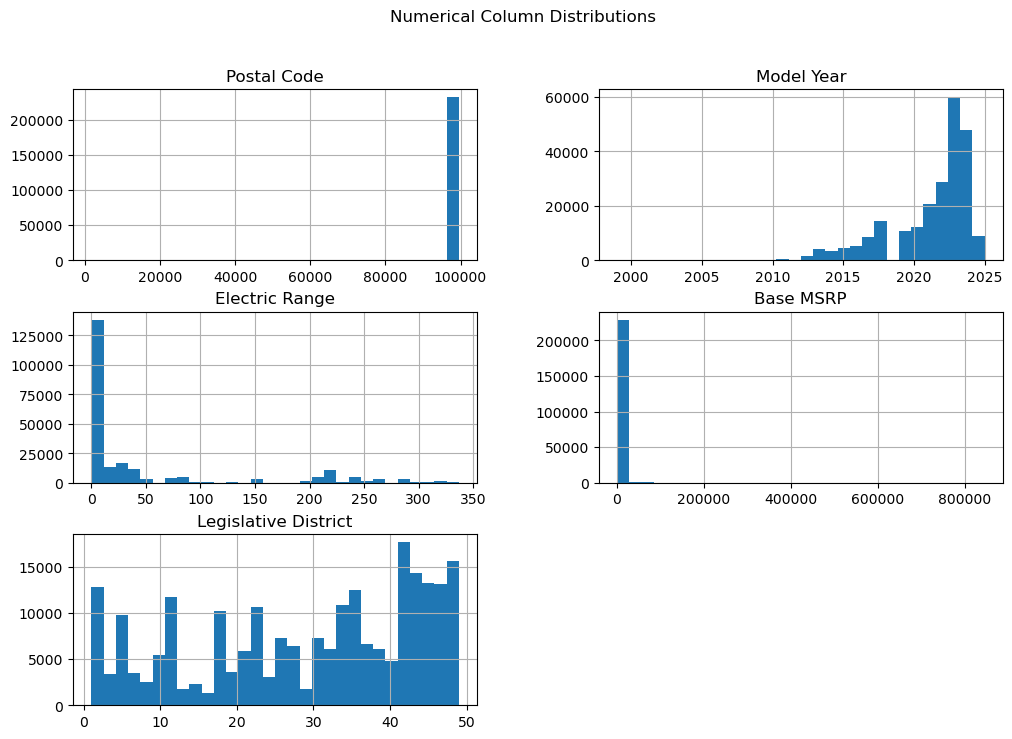

In [6]:
# Step 5: EDA - Numerical Column Analysis and Visualization
numerical_cols = df.select_dtypes(include=[np.number]).columns
df[numerical_cols].hist(figsize=(12, 8), bins=30)
plt.suptitle("Numerical Column Distributions")
plt.show()

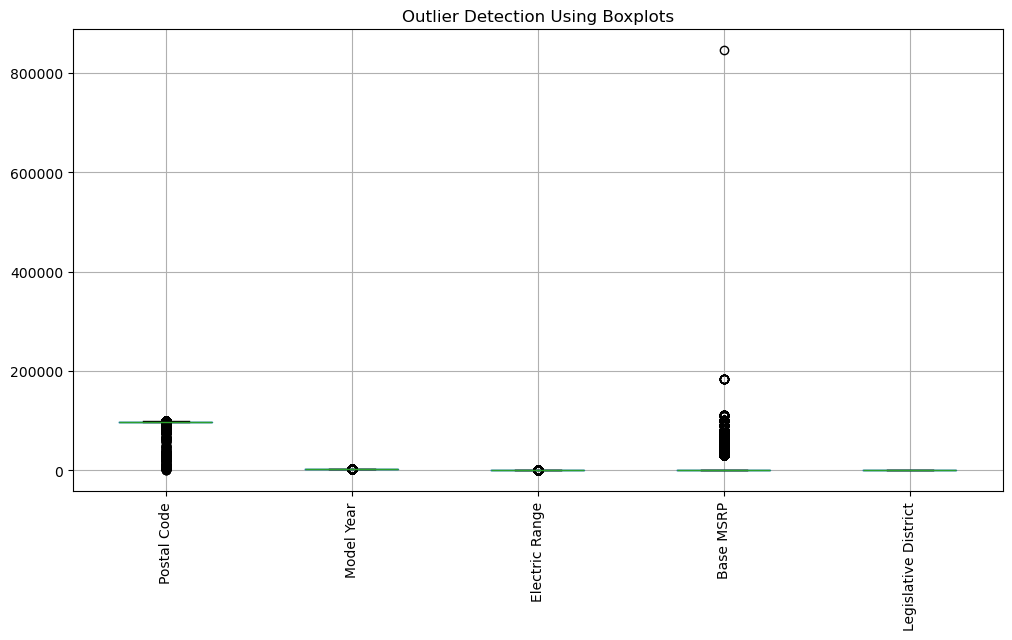

In [7]:
# Step 6: Outlier Detection using Boxplots
plt.figure(figsize=(12, 6))
df[numerical_cols].boxplot(rot=90)
plt.title("Outlier Detection Using Boxplots")
plt.show()

In [8]:
# Step 7: Skewness Analysis
skewness = df[numerical_cols].skew()
print("\nSkewness of Numerical Columns:\n", skewness)


Skewness of Numerical Columns:
 Postal Code            -29.851377
Model Year              -1.268548
Electric Range           1.831489
Base MSRP               15.597459
Legislative District    -0.431547
dtype: float64


In [9]:
# Step 8: Outlier Removal and Capping (Using IQR Method)
Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1
df_cleaned = df[~((df[numerical_cols] < (Q1 - 1.5 * IQR)) | (df[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

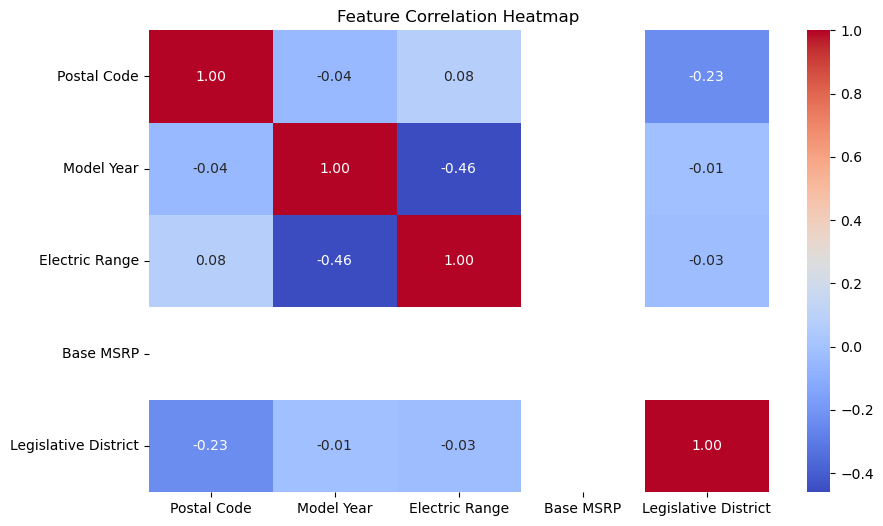

In [10]:
# Step 9: Correlation Analysis (Heatmap)
# Select only numeric columns for correlation analysis
numeric_df = df_cleaned.select_dtypes(include=[np.number])  # Filter only numeric columns

# Plot the correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

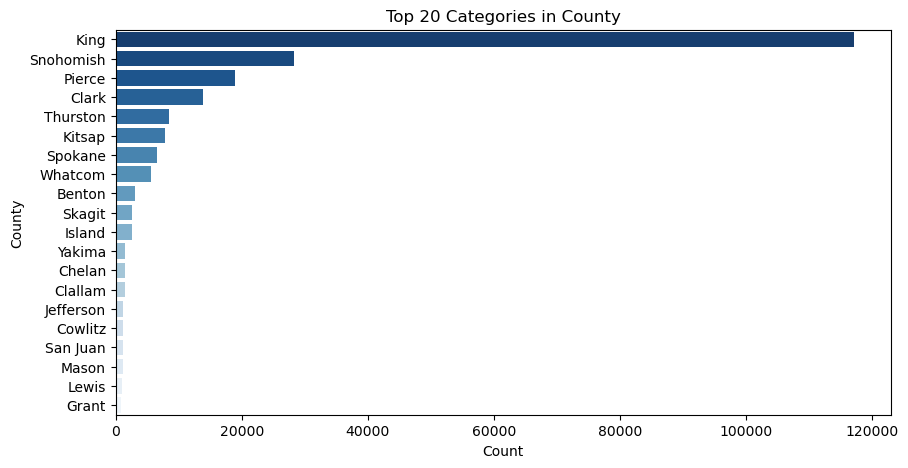

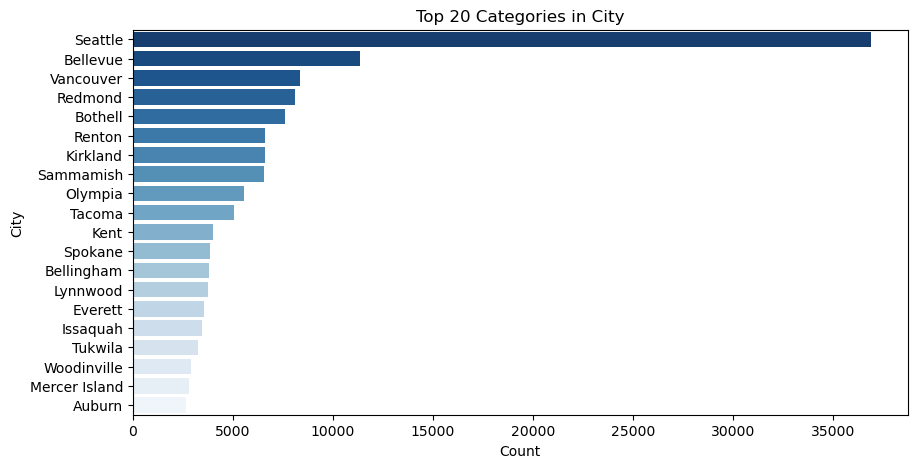

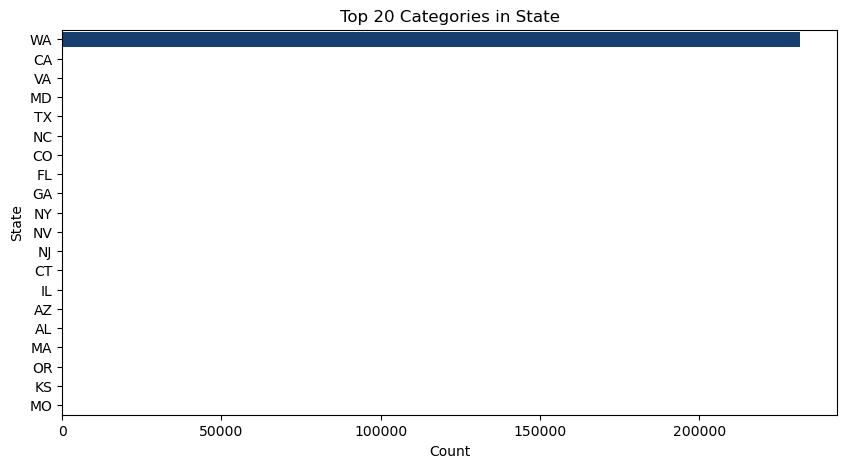

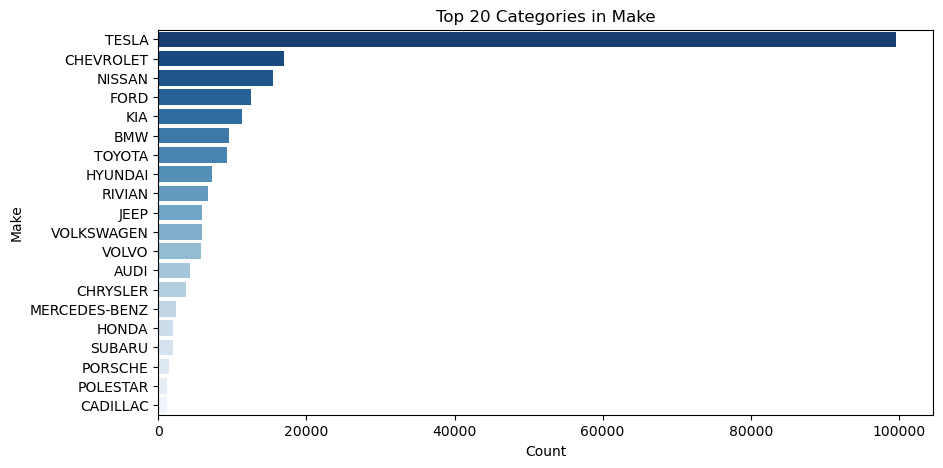

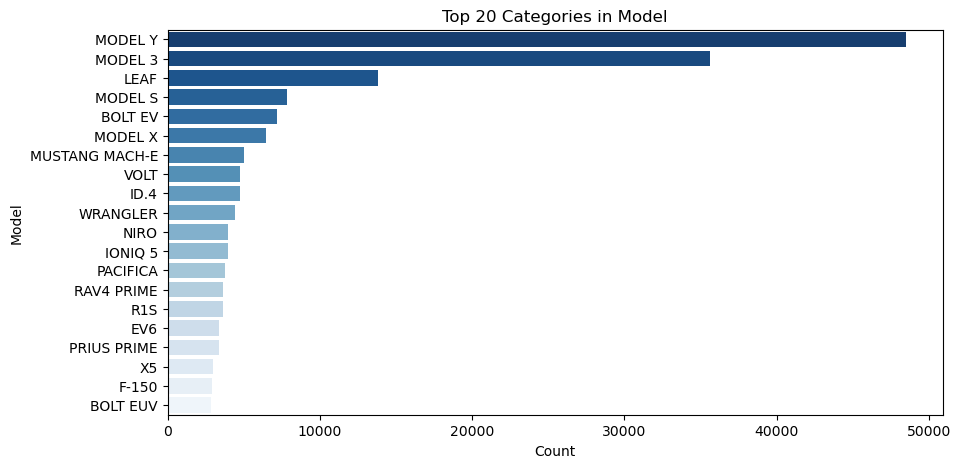

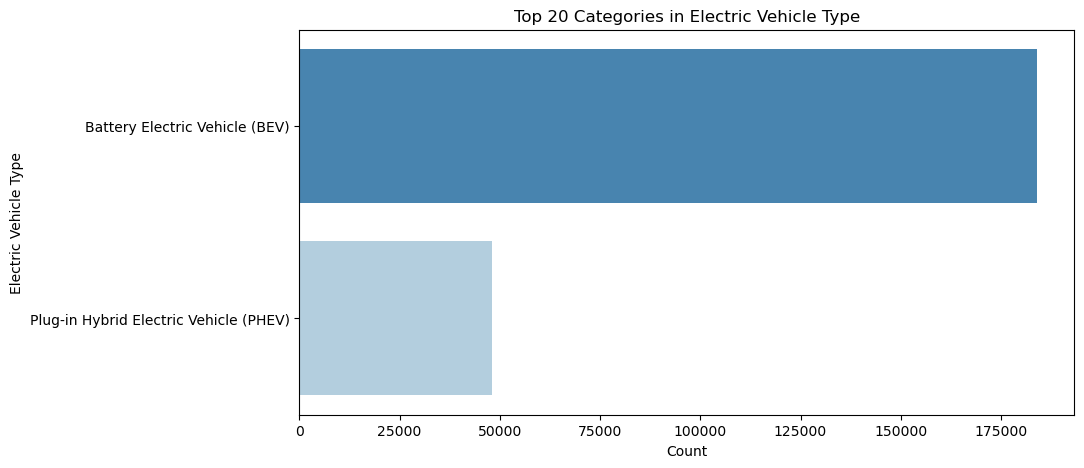

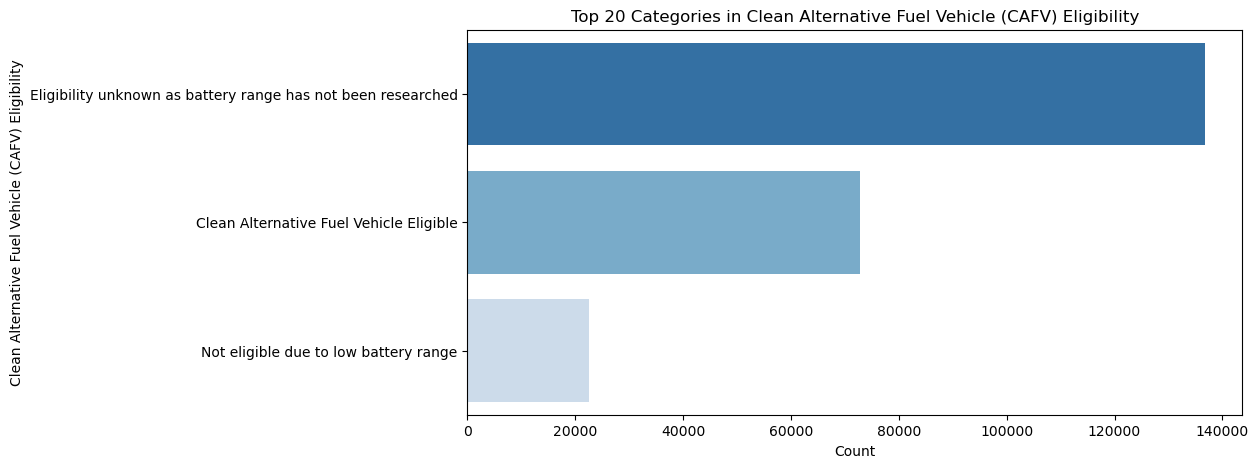

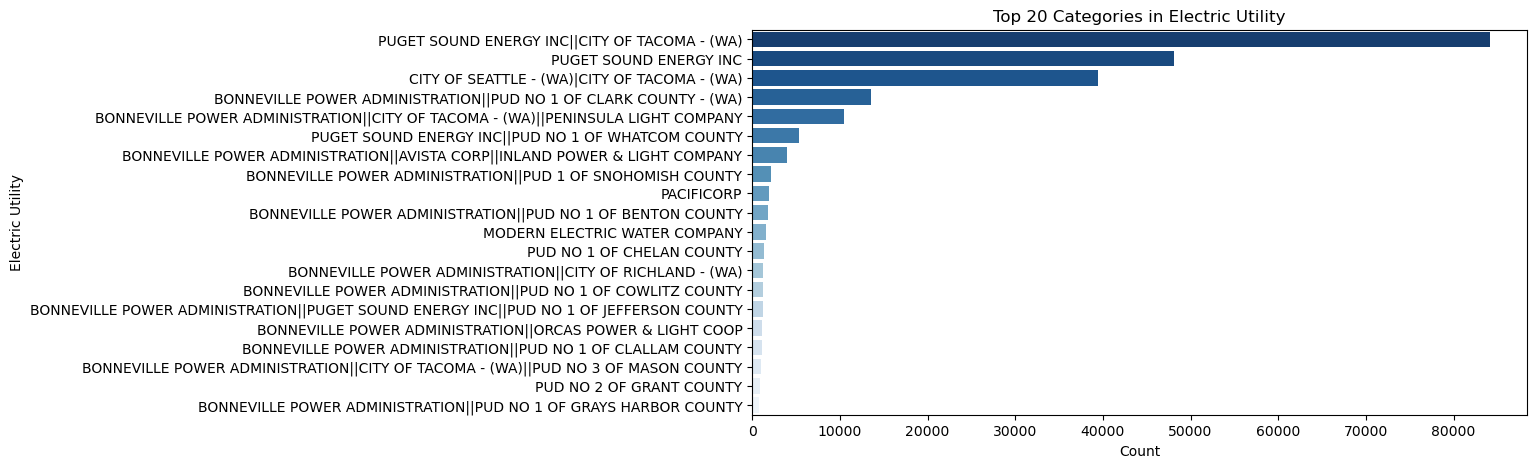

In [11]:
# Step 10: Categorical Column Analysis and Visualization
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(10, 5))  # Set figure size
    
    # Get top 20 most frequent categories (adjust if needed)
    top_categories = df[col].value_counts().nlargest(20)
    
    # Corrected barplot to avoid the FutureWarning
    sns.barplot(x=top_categories.values, y=top_categories.index, hue=top_categories.index, 
                palette='Blues_r', dodge=False, legend=False)
    
    plt.title(f"Top 20 Categories in {col}")  # Dynamic title
    plt.xlabel("Count")
    plt.ylabel(col)
    
    plt.show()

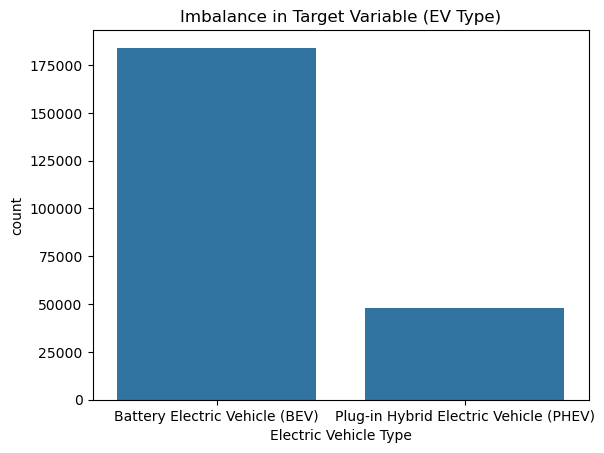

In [12]:
# Step 11: Imbalanced Data Analysis
sns.countplot(x="Electric Vehicle Type", data=df)
plt.title("Imbalance in Target Variable (EV Type)")
plt.show()

In [13]:
# Step 12: Feature Engineering
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  # Convert categorical to numeric
    label_encoders[col] = le

In [14]:
# Step 13: Feature Scaling (Standardization)
X = df.drop(columns=["Electric Vehicle Type"])  # Features
y = df["Electric Vehicle Type"]  # Target variable

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Step 14: Handling Class Imbalance using SMOTE
from imblearn.over_sampling import SMOTE  # Import SMOTE

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [16]:
# Step 15: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
print("\nTraining Set Shape:", X_train.shape, y_train.shape)
print("Testing Set Shape:", X_test.shape, y_test.shape)


Training Set Shape: (294486, 12) (294486,)
Testing Set Shape: (73622, 12) (73622,)


In [17]:
# Step 16: Feature Selection
selector = SelectKBest(score_func=f_classif, k=min(10, X_train.shape[1]))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

selected_features = X.columns[selector.get_support()]
print("\nSelected Features for Classification:", selected_features)


Selected Features for Classification: Index(['City', 'State', 'Model Year', 'Make', 'Model',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'Electric Utility'],
      dtype='object')


In [18]:
# Step 17: Machine Learning Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Standardize the dataset
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine": SVC(kernel="linear", probability=True, max_iter=500),  # Ensure this is correctly formatted
    "K-Nearest Neighbors": KNeighborsClassifier()
}

# Train and evaluate models
model_results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected)
        accuracy = accuracy_score(y_test, y_pred)
        model_results[name] = accuracy

        print(f"{name} Performance:")
        print("Accuracy:", accuracy)
        print("Classification Report:\n", classification_report(y_test, y_pred))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    except Exception as e:
        print(f"❌ {name} failed: {e}")


Training Logistic Regression...
Logistic Regression Performance:
Accuracy: 0.7736953627991633
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.82      0.78     36775
           1       0.80      0.73      0.76     36847

    accuracy                           0.77     73622
   macro avg       0.78      0.77      0.77     73622
weighted avg       0.78      0.77      0.77     73622

Confusion Matrix:
 [[30235  6540]
 [10121 26726]]

Training Random Forest...
Random Forest Performance:
Accuracy: 0.9999728342071663
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36775
           1       1.00      1.00      1.00     36847

    accuracy                           1.00     73622
   macro avg       1.00      1.00      1.00     73622
weighted avg       1.00      1.00      1.00     73622

Confusion Matrix:
 [[36774     1]
 [    1 36846]]

Training Decision T

C:\Users\alanb\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Support Vector Machine Performance:
Accuracy: 0.4046616500502567
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.14      0.19     36775
           1       0.44      0.67      0.53     36847

    accuracy                           0.40     73622
   macro avg       0.37      0.40      0.36     73622
weighted avg       0.37      0.40      0.36     73622

Confusion Matrix:
 [[ 5249 31526]
 [12304 24543]]

Training K-Nearest Neighbors...
K-Nearest Neighbors Performance:
Accuracy: 0.9985194642905654
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36775
           1       1.00      1.00      1.00     36847

    accuracy                           1.00     73622
   macro avg       1.00      1.00      1.00     73622
weighted avg       1.00      1.00      1.00     73622

Confusion Matrix:
 [[36669   106]
 [    3 36844]]



Model Ranking Based on Accuracy:
1. Random Forest: 1.0000
2. Decision Tree: 0.9999
3. K-Nearest Neighbors: 0.9985
4. Logistic Regression: 0.7737
5. Support Vector Machine: 0.4047


C:\Users\alanb\AppData\Local\Temp\ipykernel_1436\3740391465.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[x[0] for x in sorted_models], y=[x[1] for x in sorted_models], palette="Blues_r")


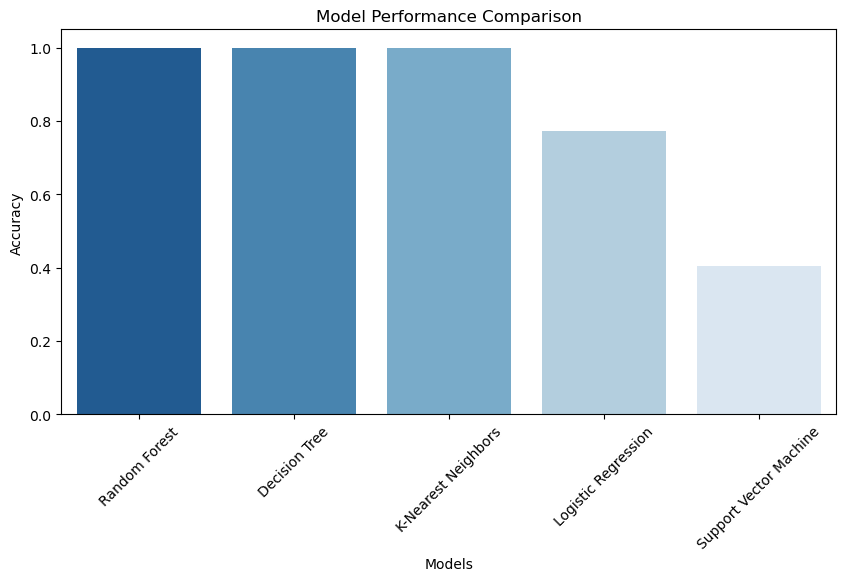

In [19]:
# Step 18: Model Comparison & Ranking
sorted_models = sorted(model_results.items(), key=lambda x: x[1], reverse=True)
print("\nModel Ranking Based on Accuracy:")
for rank, (model, acc) in enumerate(sorted_models, 1):
    print(f"{rank}. {model}: {acc:.4f}")

# Visualization of Model Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=[x[0] for x in sorted_models], y=[x[1] for x in sorted_models], palette="Blues_r")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model Performance Comparison")
plt.xticks(rotation=45)
plt.show()

In [20]:
# Step 19: Hyperparameter Tuning for Best Model
best_model_name, best_accuracy = sorted_models[0]
best_model = models[best_model_name]

if best_model_name == "Random Forest":
    param_grid = {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
elif best_model_name == "Support Vector Machine":
    param_grid = {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]}
elif best_model_name == "K-Nearest Neighbors":
    param_grid = {"n_neighbors": [3, 5, 7]}
elif best_model_name == "Logistic Regression":
    param_grid = {"C": [0.01, 0.1, 1, 10], "solver": ["lbfgs", "liblinear"]}
else:
    param_grid = {}  # Default for models that don't require tuning

if param_grid:
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)
    best_params = grid_search.best_params_
    print(f"\nBest Hyperparameters for {best_model_name}:", best_params)
    final_model = best_model.set_params(**best_params)
else:
    final_model = best_model
    print(f"\n{best_model_name} does not require hyperparameter tuning.")


Best Hyperparameters for Random Forest: {'max_depth': None, 'n_estimators': 100}


In [46]:
# Step 20: Final Model Selection & Evaluation
final_model.fit(X_train_selected, y_train)
y_final_pred = final_model.predict(X_test_selected)

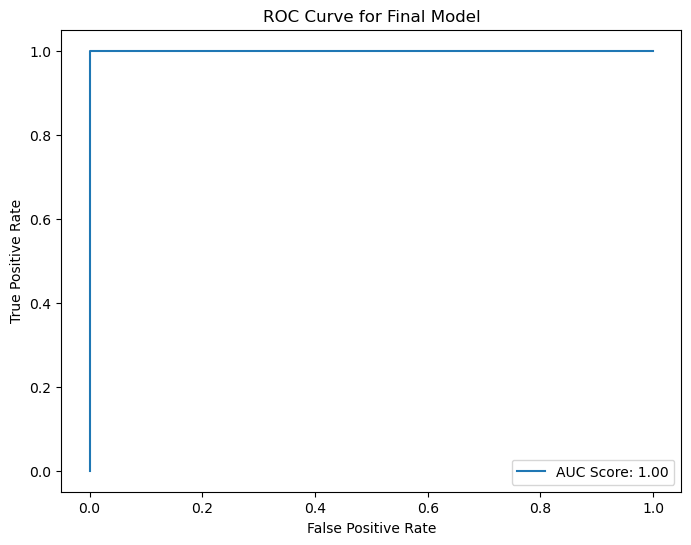


Final AUC Score: 0.9999999948341329


In [48]:
# Step 21: ROC Curve & AUC Score
if hasattr(final_model, "predict_proba"):
    y_probs = final_model.predict_proba(X_test_selected)[:, 1]
    auc_score = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC Score: {auc_score:.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Final Model")
    plt.legend()
    plt.show()
    print("\nFinal AUC Score:", auc_score)

In [50]:
# Final Model Evaluation
print("\nFinal Model Performance:")
print("Accuracy:", accuracy_score(y_test, y_final_pred))
print("Classification Report:\n", classification_report(y_test, y_final_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_final_pred))


Final Model Performance:
Accuracy: 0.9999728342071663
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36775
           1       1.00      1.00      1.00     36847

    accuracy                           1.00     73622
   macro avg       1.00      1.00      1.00     73622
weighted avg       1.00      1.00      1.00     73622

Confusion Matrix:
 [[36774     1]
 [    1 36846]]


In [37]:
import pandas as pd

# Load your dataset (modify path as needed)
df = pd.read_csv("D:\\dml\\Project\\Cleaned Dataset\\Cleaned_Electric_Vehicle_Data.csv")


In [39]:
# Define target column (update with the actual column name)
target_column = "your_correct_target_column"  # Replace with actual target column name

# Ensure the target column exists in df
if target_column not in df.columns:
    print("Error: Target column not found in dataset.")
else:
    # Define features (X) and target (y)
    X = df.drop(columns=[target_column])
    y = df[target_column]

Error: Target column not found in dataset.


In [41]:
print(df.columns)

Index(['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model',
       'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'Electric Utility'],
      dtype='object')


In [43]:
target_column = 'Electric Vehicle Type'  # Define the correct target column
X = df.drop(columns=[target_column])  # Features
y = df[target_column]  # Target variable


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Define feature columns and target column
feature_columns = ['Model Year', 'Base MSRP', 'Electric Range']  # Update based on relevant features
target_column = 'Electric Vehicle Type'  # Ensure this exists in your dataset

# Ensure the dataset contains the target column
if target_column not in df.columns:
    raise ValueError("Error: Target column not found in dataset.")

# Splitting dataset
X = df[feature_columns]
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Selection
selector = SelectKBest(score_func=f_classif, k='all')  # Adjust 'k' as needed
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


In [51]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import joblib

# Step 1: Model Selection
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

# Step 2: Hyperparameter Tuning & Evaluation
rf_param_grid = {"n_estimators": [100, 200, 300], "max_depth": [None, 10, 20]}
gb_param_grid = {"n_estimators": [100, 200], "learning_rate": [0.01, 0.1, 0.2]}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy', n_jobs=-1)

rf_grid.fit(X_train_selected, y_train)
gb_grid.fit(X_train_selected, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [53]:
# Step 3: Select Best Model
best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_

rf_score = rf_grid.best_score_
gb_score = gb_grid.best_score_

if rf_score > gb_score:
    final_model = best_rf
    model_name = "Random Forest"
else:
    final_model = best_gb
    model_name = "Gradient Boosting"

print(f"Selected Best Model: {model_name}")

Selected Best Model: Gradient Boosting


In [55]:
# Step 4: Save Best Model
joblib.dump(final_model, "best_model.pkl")
print("Best model saved successfully.")

Best model saved successfully.


In [57]:
# Step 5: Machine Learning Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', final_model)
])

pipeline.fit(X_train_selected, y_train)
joblib.dump(pipeline, "ml_pipeline.pkl")
print("Pipeline saved successfully.")

Pipeline saved successfully.


In [59]:
# Step 6: Making Predictions on Unseen Data
y_pred = pipeline.predict(X_test_selected)
print("Predictions on unseen data completed.")

Predictions on unseen data completed.


In [61]:
# Step 7: Model Performance Insights
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     36724
           1       1.00      1.00      1.00      9722

    accuracy                           1.00     46446
   macro avg       1.00      1.00      1.00     46446
weighted avg       1.00      1.00      1.00     46446

Confusion Matrix:
 [[36724     0]
 [    4  9718]]
